In [387]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from matplotlib import pyplot
import numpy as np

%matplotlib inline


In [388]:
backend = AerSimulator()

In [389]:
N_QUBITS = 5

# Steps
- [x] Hadamard gates for initialization
- [x] Oracle 
- [ ] Diffusion
- [ ] Combine the two above

In [390]:
def initialize_superposition(qc: QuantumCircuit, qr: QuantumRegister):
    """
    Initialize the quantum register in a superposition state.
    This function applies Hadamard gates to all qubits in the quantum register.
    """
    for qubit in qr:
        qc.h(qubit)

In [391]:
qr_data = QuantumRegister(N_QUBITS, name='q')
cr_data = ClassicalRegister(N_QUBITS, name='cr')
quantum_circuit = QuantumCircuit(qr_data, cr_data) # Grover's curcuit

initialize_superposition(quantum_circuit, qr_data)

quantum_circuit.draw()

┌───┐
 q_0: ┤ H ├
      ├───┤
 q_1: ┤ H ├
      ├───┤
 q_2: ┤ H ├
      ├───┤
 q_3: ┤ H ├
      ├───┤
 q_4: ┤ H ├
      └───┘
cr: 5/═════

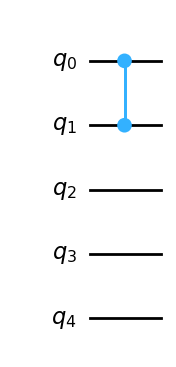

In [392]:
# Setup Oracle
def create_oracle(qr: QuantumRegister) -> QuantumCircuit:
    """
    Mark |11> as the solution state in Grover's algorithm.
    """
    oracle = QuantumCircuit(qr, name='oracle')

    oracle.cz(qr[0], qr[1])  # Controlled-Z gate for |11>
    oracle.draw('mpl')
    oracle = oracle.to_gate()
  
    return oracle

oracle = create_oracle(qr_data)

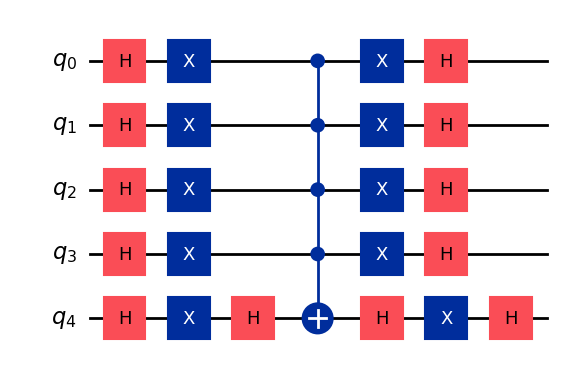

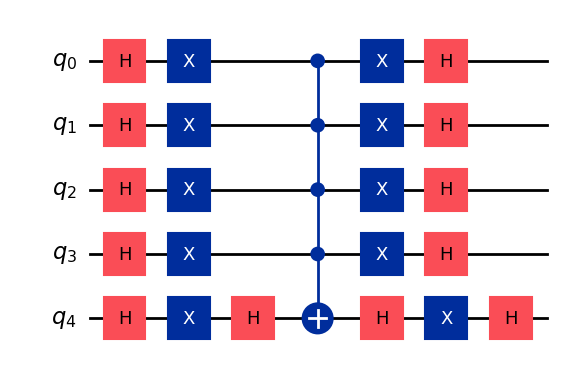

In [393]:
# Defuser
def create_diffuser(qr: QuantumRegister, num_bits: int) -> QuantumCircuit:
    """
    Create a diffuser circuit for Grover's algorithm.
    """
    diffuser = QuantumCircuit(qr, name='diffuser')
    diffuser.h(qr)

    # Flip 180 with and X gate
    diffuser.x(qr)

    # flip over the balance vercor? #TODO: figure out
    diffuser.h(num_bits - 1)
    diffuser.mcx(list(range(num_bits - 1)), num_bits - 1)  # Target is the last qubit
    diffuser.h(num_bits - 1)

    # Apply X gates to all qubits
    diffuser.x(qr)
    # apply the right amount of times?

    diffuser.h(qr)
    
    return diffuser

diffuser = create_diffuser(qr_data, N_QUBITS)
diffuser.draw('mpl')

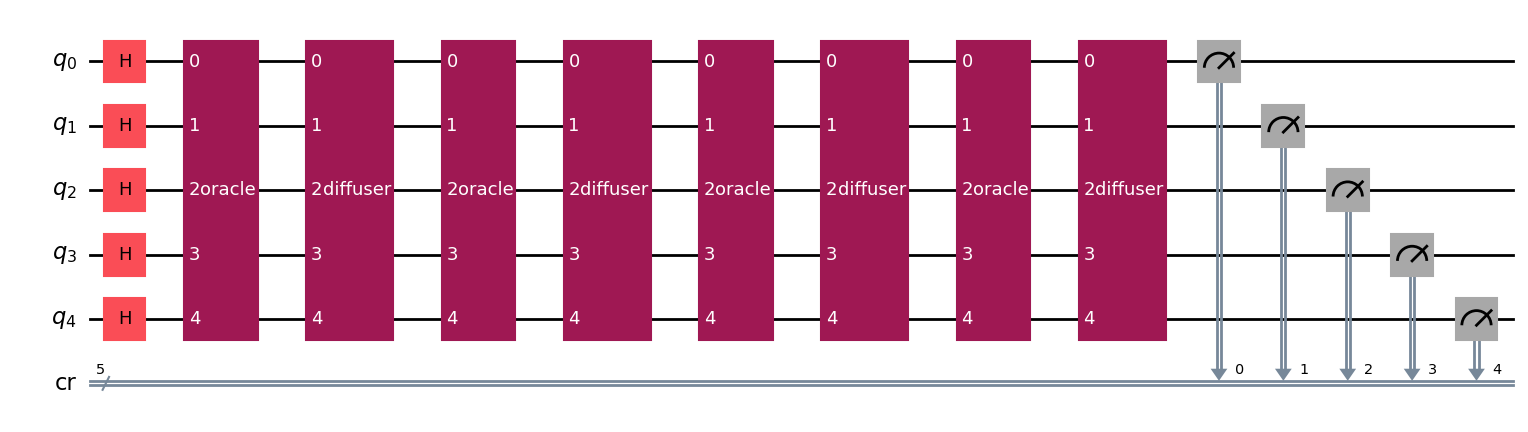

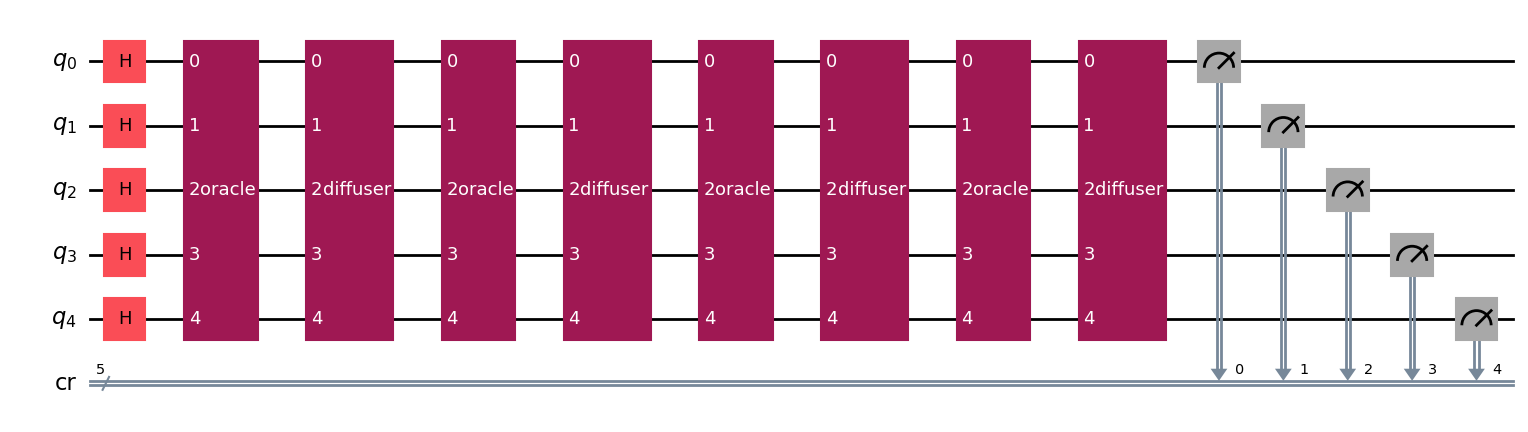

In [394]:
target_amount = 1
N = 2**N_QUBITS
k = int((np.pi / 4) * np.sqrt(N / target_amount)) 

for _ in range(k):
    quantum_circuit.append(oracle, qr_data)
    quantum_circuit.append(diffuser, qr_data)

for i in range(N_QUBITS):
    quantum_circuit.measure(qr_data[i], cr_data[i])

# quantum_circuit.measure(qr_data, cr_data)
quantum_circuit.draw('mpl')

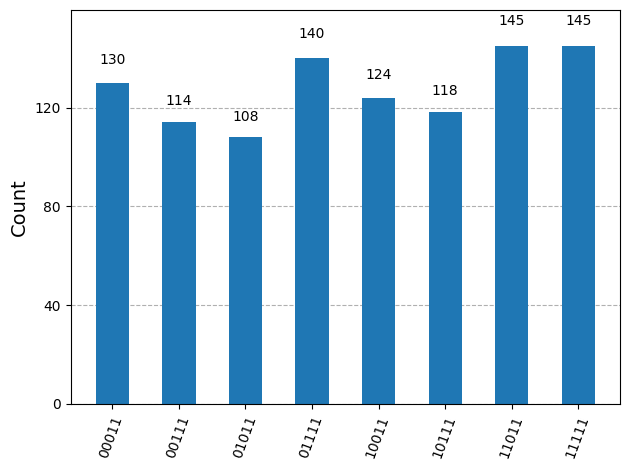

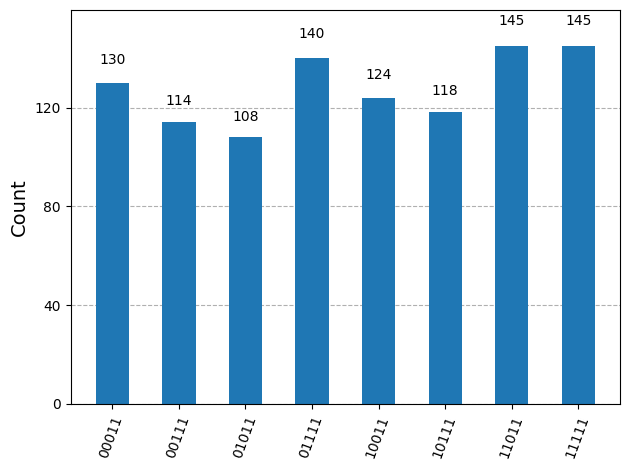

In [395]:
qc_compiled = transpile(quantum_circuit, backend)
job_sim = backend.run(qc_compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)

# Plot the result
plot_histogram(counts)